(ch_vector_add_cpu)=
# CPU 向量加法

本节在 CPU 优化 {ref}`ch_vector_add` 定义的向量加法。

## 设置

In [1]:
from tvm_book.contrib import d2ltvm

In [2]:
%matplotlib inline
import inspect
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import timeit
import tvm
from tvm import te

首先定义可重用的 plot 函数来绘制多条线，这将推广在 {ref}`ch_call_overhead` 中定义的 plot 函数。

In [3]:
# 保存到 d2ltvm
def plot(X, Y, xlabel=None, ylabel=None, legend=[], xlim=None,
         ylim=None, xscale='linear', yscale='linear', fmts=None,
         figsize=(4.5, 3)):
    """Plot multiple lines"""
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize
    axes = plt.gca()
    X, Y = np.array(X), np.array(Y)
    if X.shape != Y.shape: X = [X] * len(Y)
    if not fmts: fmts = ['-'] * len(X)
    for x, y, fmt in zip(X, Y, fmts):
        axes.plot(x, y, fmt)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend: axes.legend(legend)
    axes.grid()

# Save to the d2ltvm package
def plot_gflops(sizes, gflops, legend, xlabel='Size'):
    d2ltvm.plot(sizes, gflops, xlabel=xlabel, ylabel='GFLOPS',
             xscale='log', yscale='log',
             legend=legend, fmts=['--']*(len(gflops)-1)+['-'])

然后将 NumPy 的性能作为基准。在下面的图中，展示了向量大小与实际测量的 [GFLOPS](https://en.wikipedia.org/wiki/FLOPS) 的比较，即每秒 10 亿位浮点运算次数（giga-floating point operations per second）。

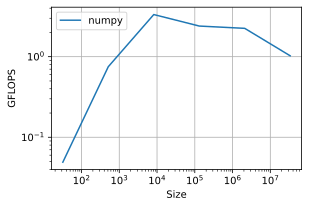

In [4]:
sizes = 2**np.arange(5, 29, 4)


def np_add(n):
    setup = ('import numpy as np\n'
             'from tvm_book.contrib import d2ltvm\n'
             f'a, b, c = d2ltvm.get_abc({n:d})')
    return timeit.Timer('np.add(a, b, out=c)', setup)


exe_times = [d2ltvm.bench_workload(np_add(n).timeit) for n in sizes]
np_gflops = sizes / 1e9 / np.array(exe_times)
plot_gflops(sizes, [np_gflops], ['numpy'])

可以看到，性能首先随着向量长度的增加而增加，这是由于工作负载较小时系统开销占主导地位。当无法将所有数据放入缓存时，性能就会下降。

## 默认 Schedule

在下面的代码块中，定义了可重用的方法来对 TVM 性能进行基准测试。它接受三个参数

1. `func`：它返回 schedule 及其对应的符号张量参数
2. `sizes`：列表指定向量的长度
3. `target`：本章与 CPU 相关的机器目标，下一章将与 GPU 相关。

In [5]:
# Save to the d2ltvm package.
def bench_vector_add_tvm(func, sizes, target):
    ctx = tvm.device(target, 0)
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, ctx, number=nrepeats)
        return timer(a, b, c).mean * nrepeats
    times = []
    for n in sizes:
        s, (A, B, C) = func(int(n))
        mod = tvm.build(s, [A, B, C], target)
        a, b, c = d2ltvm.get_abc(n, lambda x: tvm.nd.array(x, ctx))
        times.append(d2ltvm.bench_workload(workload))
    return sizes / 1e9 / np.array(times)

默认的调度是普通的 one-level for 循环程序。

In [6]:
def default(n):
    A, B, C = d2ltvm.vector_add(n)
    s = te.create_schedule(C.op)
    return s, (A, B, C)

s, args = default(64)
m = tvm.lower(s, args, simple_mode=True)
m["main"]

PrimFunc([a, b, c]) attrs={"from_legacy_te_schedule": (bool)1, "global_symbol": "main", "tir.noalias": (bool)1} {
  for (i, 0, 64) {
    c[i] = (a[i] + b[i])
  }
}

记得在 {ref}`ch_cpu_arch` 发现我们的 CPU 支持 AVX-512，这样我们传递 `-mcpu=skylake-avx512` 给 LLVM 以便其在可能的情况下生成 AVX-512 指令。在下面的代码中，打印了几行生成的 LLVM 代码。

In [7]:
target = 'llvm -mcpu=skylake-avx512'
mod = tvm.build(s, args, target)
print(mod.get_source()[:500])

; ModuleID = 'TVMMod'
source_filename = "TVMMod"
target datalayout = "e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-pc-linux-gnu"

%0 = type { i8*, %1, i32, %2, i64*, i64*, i64 }
%1 = type { i32, i32 }
%2 = type { i8, i8, i16 }

@__TVMAPISetLastError = linkonce dllexport local_unnamed_addr global void (i8*)* null, align 8
@.str = private constant [69 x i8] c"Assert fail: (num_args == 3), default_function: num_args should be 3\00", align 1
@.str.1


如果你不熟悉 LLVM IR，你可能会发现它不太可读。但在大多数情况下，您不需要太担心，只阅读的类 C 的伪代码就足以研究性能了。

基准使用默认的调度。

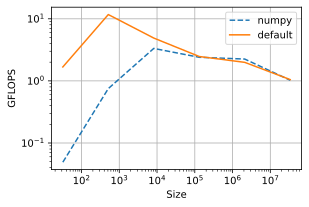

In [8]:
default_gflops = bench_vector_add_tvm(default, sizes, target)
plot_gflops(sizes, [np_gflops, default_gflops], ['numpy', 'default'])

当向量大小较小时，默认调度优于 NumPy，即该方法中 TVM 的函数调用开销小于 NumPy。当增加向量大小时，性能会下降，因为数据无法放入最后一级缓存中，这并不奇怪。

## 并行化

默认情况下未启用的一个重要优化是线程级并行。向量加法算子是 [令人尴尬的并行工作负载](https://en.wikipedia.org/wiki/Embarrassingly_parallel)，可以将 for 循环改为并行的 for 循环。在 TVM 中，首先通过 `s[C]` 获得输出符号 `C` 的调度程序，然后将计算的并行化施加到它的第一个轴 `C.op.axis[0]`。

In [9]:
def parallel(n):
    s, (A, B, C) = default(n)
    # add thread-level parallelism
    s[C].parallel(C.op.axis[0])
    return s, (A, B, C)

s, args = parallel(64)
m = tvm.lower(s, args, simple_mode=True)
print(m)

@main = primfn(a_1: handle, b_1: handle, c_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {a: Buffer(a_2: Pointer(float32), float32, [64], []),
             b: Buffer(b_2: Pointer(float32), float32, [64], []),
             c: Buffer(c_2: Pointer(float32), float32, [64], [])}
  buffer_map = {a_1: a, b_1: b, c_1: c}
  preflattened_buffer_map = {a_1: a_3: Buffer(a_2, float32, [64], []), b_1: b_3: Buffer(b_2, float32, [64], []), c_1: c_3: Buffer(c_2, float32, [64], [])} {
  for (i: int32, 0, 64) "parallel" {
    c[i] = (a[i] + b[i])
  }
}




可以看到，在上面的伪代码中，`for` 被更改为 `parallel`。这意味着迭代可以由多个线程并行执行。在 CPU 内核为 $t$ 的系统上的典型实现是，首先创建 $t$ 线程，每个内核有一个线程，然后线程 $i$ 将执行 `j % t = i` 时的 $j$ 块。所有这些线程将在它们的专用核上同时运行以实现并行化，并在完成一个块之后返回来检索另一个块执行。这通常称为 [round-robin scheduling](https://en.wikipedia.org/wiki/Round-robin_scheduling)，如果每个线程都以相同的速度运行，并且每个迭代都有大致相同的工作负载，那么这种调度就可以很好地工作。

TVM 的线程级并行化实现是 round-robin 的特殊情况，它平均将并行的长度 $n$ 循环划分为 $t$ 块。因此，每个线程只需要处理一个块。此外，TVM 运行时将每个工作线程绑定到一个不相交的物理核心，以避免资源争用和线程迁移开销。还有其他线程级并行化方案，比如更动态的 [consumer-producer scheduling](https://en.wikipedia.org/wiki/Producer–consumer_problem)。

然后检查向量的并行化，并通过下面的代码块绘制比较图。

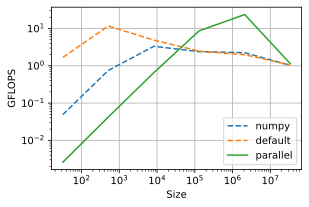

In [10]:
parallel_gflops = bench_vector_add_tvm(parallel, sizes, target)
plot_gflops(sizes, [np_gflops, default_gflops, parallel_gflops],
     ['numpy', 'default', 'parallel'])

与之前得到的结果相比，当工作负载较大时，例如向量长度超过 $10^4$ 时，并行化显著提高了性能。但是，并行化开销会影响小工作负载的性能，在这种情况下，单线程甚至更快。随着多核的出现，性能下降的幅度越大，导致 L2 缓存的总量就越大。

## 张量化

单个核可以有 SIMD 单元来同时运行多个算术运算，就像在 {ref}`ch_cpu_arch` 中看到的那样。尽管上面循环中的一个迭代只有一个 add 运算，但可以在一个迭代中显式地分配更多运算，并要求编译器使用 SIMD 指令来处理它们。

做到这一点的方法是首先使用 `factor` 将 one-level 的 for 循环分割成 two-level 嵌套的 for 循环。内部循环由 `factor` 原始迭代组成，这些迭代将被相应地分组在一起，以在一个 core 上的 SIMD 指令中执行。外部循环中的迭代仍然并行运行。

In [11]:
def vectorized(n):
    s, (A, B, C) = default(n)
    outer, inner = s[C].split(C.op.axis[0], factor=8)
    s[C].parallel(outer)
    s[C].vectorize(inner)
    return s, (A, B, C)

s, args = vectorized(64)
m = tvm.lower(s, args, simple_mode=False)
print(m)

@main = primfn(a_1: handle, b_1: handle, c_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {a: Buffer(a_2: Pointer(float32), float32, [64], []),
             b: Buffer(b_2: Pointer(float32), float32, [64], []),
             c: Buffer(c_2: Pointer(float32), float32, [64], [])}
  buffer_map = {a_1: a, b_1: b, c_1: c}
  preflattened_buffer_map = {a_1: a_3: Buffer(a_2, float32, [64], []), b_1: b_3: Buffer(b_2, float32, [64], []), c_1: c_3: Buffer(c_2, float32, [64], [])} {
  for (i.outer: int32, 0, 8) "parallel" {
    let cse_var_1: int32 = (i.outer*8)
    c[ramp(cse_var_1, 1, 8)] = (a[ramp(cse_var_1, 1, 8)] + b[ramp(cse_var_1, 1, 8)])
  }
}




可以看到，外层 for 循环被归约为 8 次迭代，而内部 for 循环被 stride 为 1，width 为 8 的 `ramp` 向量化。`ramp` 的定义继承自 [Halide](https://halide-lang.org/docs/struct_halide_1_1_internal_1_1_ramp.html)。

再次检查向量化的性能，并通过下面的代码块绘制比较图。

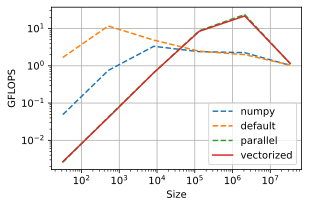

In [12]:
vectorized_gflops = bench_vector_add_tvm(vectorized, sizes, target)
plot_gflops(sizes, [np_gflops, default_gflops, parallel_gflops, vectorized_gflops],
     ['numpy', 'default', 'parallel', 'vectorized'])

向量化版本的性能几乎和普通的并行化版本一样。部分原因是，向量加法的瓶颈是内存带宽，而不是计算，而 SIMD 只有助于后者。稍后将看到它对计算密集型工作负载（如矩阵乘法）有更多帮助。

## 小结

- 默认调度生成朴素的单线程 CPU 程序。
- 并行化可以提高大工作负载的性能。
- 如果系统支持 SIMD，可以分割 for 循环，然后对内部循环进行向量化。